**Mid-bootcamp project: Regression**

# Import tools

In [ ]:
import pandas as pd
import numpy as np
import datetime
import warnings

warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

%matplotlib inline

pd.set_option('display.max_columns', None)

# Load data



**Importing SQL query**

In [ ]:
from sqlalchemy import create_engine
import pandas as pd
import getpass  
password = getpass.getpass()

In [ ]:
# Establishing the connection with MySQL
connection_string = 'mysql+pymysql://root:' + password + '@localhost/house_price_regression'
engine = create_engine(connection_string)
data = pd.read_sql_query('SELECT * from house_price_data', engine)
data.head()

# Exploration of the data

In [ ]:
data.shape

In [ ]:
data.info()

In [ ]:
data.isna().sum()

In [ ]:
data.isin(['', ' ']).sum()

In [ ]:
data.describe()

**Splitting continuous and discrete values (Sara)**

In [ ]:
continuous_data = pd.DataFrame()
discrete_data = pd.DataFrame()

for i in data:
    if len(data[i].unique()) < 120:
        discrete_data[i] = data[i]
    else:
        continuous_data[i] = data[i]

**Exploring the unique values**

In [ ]:
for i in data.columns.tolist():         
    print(i, len(data[i].unique()))

In [ ]:
#check quantity of each unique value per column
for i in data:
    print('Catagory: ', i)
    print(data[i].value_counts())
    print('\n')

In [ ]:
# checking uniques values that are less than 100
for i in data:
    if len(data[i].unique()) < 100:
        print('.....',i,'.....')
        print( data[i].unique())

In [ ]:
# printing the distribution plot of the columns
for i in continuous_data:
    print(i)
    sns.distplot(data[i], bins=20)
    plt.show()

**Checking the outliers**

In [ ]:
outliers_list = pd.DataFrame (columns = ['name', 'perc'])
def get_outliers(data):
    outliers_list = pd.DataFrame (columns = ['name', 'perc'])
    for i in data:  
        iqr = np.percentile(data[i],75) - np.percentile(data[i],25)
        upper_limit = np.percentile(data[i],75) + 1.5*iqr    
        outliers = data[data[i] > upper_limit].index.tolist()       
        
        
        if len(outliers) > 0:
            print (i)
            print("The upper whisker is at: %4.2f" % upper_limit)
            print("The number of points outside the upper whisker is: ",len(outliers))
            print("Percentage from total", round(len(outliers)*100/len(data[i]),2), '%')
            ax, fig = plt.subplots(figsize = (20,2))
            sns.boxplot(x=i, data=data)
            plt.show()
        else:
            print (i, 'has no outliers')
        print()
        
        perc = round(len(outliers)*100/len(data[i]),2)
        outliers_list = outliers_list.append({'name': i, 'perc': perc}, ignore_index=True)
    outliers_list = outliers_list.sort_values(by=['perc'],ascending=False)
    return outliers_list
        

get_outliers(data)


**Exploring the continuous data**

In [ ]:
# checking the skewness 
from scipy.stats import skew
continuous_data.apply(skew)

In [ ]:
# checking kurtosis 
from scipy.stats import kurtosis
for i in continuous_data:
    print(i, '--------', kurtosis(continuous_data[i]))

In [ ]:
# qualitative test of normality (Q-Q Plot)
from statsmodels.graphics.gofplots import qqplot
from matplotlib import pyplot
 
cols = list(continuous_data.columns)
for col in cols:
    print('Q-Q plot for variable:', col)
    qqplot(continuous_data[col], line='s')
    plt.show()

# Cleaning the data

**Dropping the 'Id' column**



In [ ]:
data = data.drop(['id'], axis=1)
#in a later attempt we still use the id to drop duplicates

**Replacing the value 33 in 'bedrooms' for 3 (possible typo)**


In [ ]:
data['bedrooms'] = data['bedrooms'].replace(33, 3)

Prepared codes if we need categorical data for further analysis (Kati)

```
renovation = []
for x in data['yr_renovated']:
    if x != 0:
        renovation.append('Yes')
    else:
        renovation.append('No') 
data['renovation'] = renovation

list(np.unique(data['waterfront']))

waterfront = []
for x in data['waterfront']:
    if x != 0:
        waterfront.append('Yes')
    else:
        waterfront.append('No')
data['waterfront'] = waterfront
```

# Check for multicollinearity

In [ ]:
corr_data = data
 
correlations_matrix = corr_data.corr()
mask = np.zeros_like(correlations_matrix)
mask[np.triu_indices_from(mask)] = True
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(correlations_matrix, mask=mask, annot=True)
plt.show() # Half correlation matrix

# Data transformation

**Prepared a master function for data transformations**

In [ ]:
def log_transform_clean(x):
    if np.isfinite(x) and x != 0:
        return np.log(x)
    else:
        return np.NAN

**Prepared a master function for log transformation and scale of the data**




In [ ]:
def log_scale_model(dataset, target_column, log_column, scale):
    # log scale on target column target_column
    dataset[target_column] = data[target_column].apply(log_transform_clean)
    
    # log scale on columns 'sqft_lot' and 'sqft_lot15'
    for i in log_column:
        dataset[i] = dataset[i].apply(log_transform_clean)
    # dropping the target feature
    X = dataset.drop([target_column], axis=1)
    y = dataset[target_column]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)
    
    # removing the features that were trasformed with log
    # X_train
    X_train_log_features = pd.DataFrame()
    for i in log_column:
        X_train_log_features[i] = X_train[i]
        X_train = X_train.drop([i], axis=1)
    # X_test
    X_test_log_features = pd.DataFrame()    
    for i in log_column:
        X_test_log_features[i] = X_test[i]
        X_test = X_test.drop([i], axis=1)

    # scale of the data
    if scale == 'StandardScaler':
        from sklearn.preprocessing import StandardScaler
        sc = StandardScaler()
        X_train = sc.fit_transform(X_train)
        X_test = sc.transform (X_test)
    elif scale == 'MinMaxScaler':
        from sklearn.preprocessing import MinMaxScaler
        minmax =  MinMaxScaler()
        X_train = minmax.fit_transform(X_train)
        X_test = minmax.transform (X_test)
    elif scale == 'Normalizer':
        # applying the normalizer
        from sklearn.preprocessing import Normalizer
        norm =  Normalizer()
        X_train = norm.fit_transform(X_train)
        X_test = norm.transform (X_test)
        
    
    # reseting indexes for X_train and X_test and concatenating them with the features transformed with log
    # X_train
    X_train_log_features = X_train_log_features.reset_index()
    X_train_log_features = X_train_log_features.drop(['index'], axis=1)
    X_train = pd.DataFrame(X_train)
    for i in log_column:
        X_train = pd.concat([X_train, X_train_log_features[i]], axis=1)
    # X_test
    X_test_log_features = X_test_log_features.reset_index()
    X_test_log_features = X_test_log_features.drop(['index'], axis=1)
    X_test = pd.DataFrame(X_test)
    for i in log_column:
        X_test = pd.concat([X_test, X_test_log_features[i]], axis=1)
    
    # undoing the log of the target
    y_train = np.exp(y_train)
    y_test = np.exp(y_test)

    # model evaluation
    return model_evaluation(X_train, X_test, y_train, y_test)        
    

# Model

**Prepared a master function to get the error metrics from the models and an automatic evaluation which model is best.**

In [ ]:
def get_metrics(y_test,predictions,X_test):
    from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
    from sklearn.metrics import r2_score

    mae = round(mean_absolute_error(y_test,predictions),3)
    mse = round(mean_squared_error(y_test,predictions),3)
    root_mse = round(np.sqrt(mean_squared_error(y_test,predictions)),3)
    r2 = round(r2_score(y_test, predictions),3)
    N = len(X_test)
    p = X_test.shape[1]
    adj_r2 = 1-((1-r2)*(N-1)/(N-p-1))
    adjusted_R2 = round(adj_r2, 2)
    re = round(np.mean(np.abs((y_test - predictions) / y_test)), 2)
    return mae, mse,root_mse,r2,adj_r2, re

# run the data on each model and get metrics from them
def model_evaluation(X_train, X_test, y_train, y_test, n_neighbors=4):
    from sklearn.model_selection import train_test_split
    from sklearn.linear_model import LinearRegression
    from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
    from sklearn.metrics import r2_score
    from sklearn import linear_model


    # creates a dataframe to store de metrics
    metrics = pd.DataFrame (columns = ['name','mae', 'mse', 'root_mse', 'r2', 'adjr2', 're'])    
  
    #LR
    print('Linear Regression')
    lm = linear_model.LinearRegression()
    model = lm.fit(X_train,y_train)
    predictions  = lm.predict(X_test)
    sns.scatterplot(y = predictions, x = y_test)
    plt.show()
    mae, mse, root_mse, r2, adjr2, re = get_metrics(y_test,predictions,X_test)
    metrics = metrics.append({'name':'Linear Regression','mae': mae, 'mse': mse, 'root_mse' : root_mse, 'r2' : r2, 'adjr2' : adjr2, 're':re}, ignore_index=True)
   
    #KNN   
    print('KNeighbors Regressor')
    from sklearn.neighbors import KNeighborsRegressor
    knn_model = KNeighborsRegressor(n_neighbors=n_neighbors) 
    knn_model.fit(X_train, y_train)
    predictions = knn_model.predict(X_test)
    sns.scatterplot(y = predictions, x = y_test)
    plt.show()
    mae, mse, root_mse, r2, adjr2, re = get_metrics(y_test,predictions,X_test)
    metrics = metrics.append({'name':'KNeighbors Regressor','mae': mae, 'mse': mse, 'root_mse' : root_mse, 'r2' : r2, 'adjr2' : adjr2, 're':re}, ignore_index=True)
     
    #MLPRegressor
    print('MLP Regressor')
    from sklearn.neural_network import MLPRegressor
    from sklearn.datasets import make_regression
    mlp_model = MLPRegressor(hidden_layer_sizes=(100), alpha=1e-05, max_iter=10, activation="relu", random_state=1)
    mlp_model.fit(X_train, y_train)
    predictions = mlp_model.predict(X_test)
    sns.scatterplot(y = predictions, x = y_test)
    plt.show()
    mae, mse, root_mse, r2, adjr2, re = get_metrics(y_test,predictions,X_test)
    metrics = metrics.append({'name':'MLP Regressor','mae': mae, 'mse': mse, 'root_mse' : root_mse, 'r2' : r2, 'adjr2' : adjr2, 're':re}, ignore_index=True)
   
    #PolynomialFeatures (Josie)
    print('Polynomial Features')
    from sklearn.linear_model import Ridge
    from sklearn.preprocessing import PolynomialFeatures
    from sklearn.pipeline import make_pipeline
    pf_model = make_pipeline(PolynomialFeatures(2), Ridge())
    pf_model.fit(X_train, y_train)
    predictions = pf_model.predict(X_test)
    sns.scatterplot(y = predictions, x = y_test)
    plt.show()        
    mae, mse, root_mse, r2, adjr2, re = get_metrics(y_test,predictions,X_test)
    metrics = metrics.append({'name':'Polynomial Features','mae': mae, 'mse': mse, 'root_mse' : root_mse, 'r2' : r2, 'adjr2' : adjr2, 're':re}, ignore_index=True)
   
    # DecisionTree (Josie)
    print('Decision Tree')
    from sklearn.tree import DecisionTreeRegressor
    dt_model = DecisionTreeRegressor()
    dt_model.fit(X_train, y_train)
    predictions = dt_model.predict(X_test)
    sns.scatterplot(y = predictions, x = y_test)
    plt.show()        
    mae, mse, root_mse, r2, adjr2, re = get_metrics(y_test,predictions,X_test)
    metrics = metrics.append({'name':'Decision Tree','mae': mae, 'mse': mse, 'root_mse' : root_mse, 'r2' : r2, 'adjr2' : adjr2, 're':re}, ignore_index=True)
     
    #RandomForest (Josie)
    print('Random Forest')
    from sklearn.ensemble import RandomForestRegressor
    rf_model = RandomForestRegressor()
    rf_model.fit(X_train, y_train)
    predictions = rf_model.predict(X_test)
    sns.scatterplot(y = predictions, x = y_test)
    plt.show()        
    mae, mse, root_mse, r2, adjr2, re = get_metrics(y_test,predictions,X_test)
    metrics = metrics.append({'name':'Random Forest','mae': mae, 'mse': mse, 'root_mse' : root_mse, 'r2' : r2, 'adjr2' : adjr2, 're':re}, ignore_index=True)
     

    # sort the metrics by R2
    metrics = metrics.sort_values(by=['r2'],ascending=False)   
    
    # print the highest values
    print(metrics['name'][metrics['mae'].idxmin()], 'has the lowest Mean Absolute Error')  
    print(metrics['name'][metrics['mse'].idxmin()], 'has the lowest Mean Squared Error')       
    print(metrics['name'][metrics['root_mse'].idxmin()], 'has the lowest Rooted Mean Squared Error')  
    print(metrics['name'][metrics['r2'].idxmax()], 'has the highest R2' )    
    print(metrics['name'][metrics['adjr2'].idxmax()], 'has the highest Adjusted R2')
    print(metrics['name'][metrics['re'].idxmin()], 'has the lowest Relative Error')
    
    return metrics

**Checking the model without any transformation on the dataset.**

In [ ]:
from sklearn.model_selection import train_test_split
X = data.drop(['price'], axis=1)
y = data['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)
model_evaluation(X_train, X_test, y_train, y_test)

error metrics for this attempt ('raw' data):

#Attempt 1: Log Transformation
We used the log transformation for all variables with high skewness (including the target).

**Getting a copy of the fresh dataset**

In [ ]:
data_attempt_1 = data.copy()


**Log Transformation**

In [ ]:
def log_transform_clean(x):
    x = np.log(x)
    if np.isfinite(x):
        return x
    else:
        return 0 
      
      
# log transformation on target column 'price'
data_attempt_1['price'] = data_attempt_1['price'].apply(log_transform_clean)
sns.distplot(data_attempt_1['price']);
plt.show()

In [ ]:
# log transformation on columns 'sqft_lot' and 'sqft_lot15'
data_attempt_1['sqft_lot'] = data_attempt_1['sqft_lot'].apply(log_transform_clean)
sns.distplot(data_attempt_1['sqft_lot']);
plt.show()

data_attempt_1['sqft_lot15'] = data_attempt_1['sqft_lot15'].apply(log_transform_clean)
sns.distplot(data_attempt_1['sqft_lot15']);
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split  

# dropping the target feature
X = data_attempt_1.drop(['price'], axis=1)
y = data_attempt_1['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)

In [ ]:
# undoing the log of the target
y_train = np.exp(y_train)
y_test = np.exp(y_test)

# model evaluation
model_evaluation(X_train, X_test, y_train, y_test)

error metrics for attempt 1:

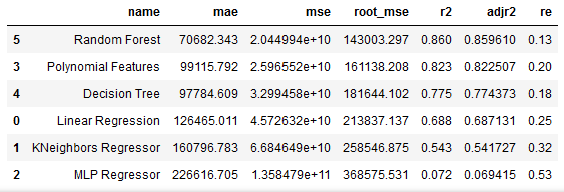

# Attempt 2: drop lat and long

## Log & StandardScaler
- Logarithm transformation on columns sqft_lot and sqft_log15 and Standard Scaler on the rest of features. We also dropped lat and long columns for this attempt

**Creating a copy of the data set**

In [ ]:
data_attempt_2 = data.copy()
data_attempt_2 = data_attempt_2.drop(['lat'], axis=1)
data_attempt_2 = data_attempt_2.drop(['long'], axis=1)


In [ ]:
log_scale_model(data_attempt_2, 'price', ['sqft_lot','sqft_lot15'], 'StandardScaler')

## Log & Min Max Scaler
- We did the logarithmic transformation on the same columns, and applied Min Max Scaler. We also dropped lat and long columns

**Creating a copy of the data set**

In [ ]:
data_attempt_2 = data.copy()
data_attempt_2 = data_attempt_2.drop(['lat'], axis=1)
data_attempt_2 = data_attempt_2.drop(['long'], axis=1)

In [ ]:
log_scale_model(data_attempt_2, 'price', ['sqft_lot','sqft_lot15'], 'MinMaxScaler')

## Log & Normalizer

- We did the logarithmic transformation on the same columns, and applied Normalizer. In this attempt we also dropped lat and long columns

**Creating a copy of the data set**

In [ ]:
data_attempt_3 = data.copy()
data_attempt_3= data_attempt_3.drop(['lat'], axis=1)
data_attempt_3 = data_attempt_3.drop(['long'], axis=1)

In [ ]:
log_scale_model(data_attempt_3, 'price', ['sqft_lot','sqft_lot15'], 'MinMaxScaler')

> ...only tiny improvements of the model.

# Attempt 3: using location (lat/long) in the predictions
Another attempt, this time with removing ID duplicates and using latitude and longitude in our models to see if it improves our metrics



**Creating a copy of the fresh data set**

dropping duplicates in the 'ID' column and dropping it after


In [ ]:
data_attempt_3 = pd.read_sql_query('SELECT * from house_price_data', engine)

data_attempt_3.shape

data_attempt_3 = data_attempt_3.drop_duplicates('id', keep='last')

data_attempt_3.shape

data_attempt_3 = data_attempt_3.drop(['id'], axis=1)

**Exploration of the data**

In [ ]:
data_attempt_3.info()

In [ ]:
data_attempt_3.describe()

**Splitting the data in continuous and discrete**

In [ ]:
continuous_data = pd.DataFrame()
discrete_data = pd.DataFrame()

for i in data_attempt_3:
    if len(data_attempt_3[i].unique()) < 120:
        discrete_data[i] = data_attempt_3[i]
    else:
        continuous_data[i] = data_attempt_3[i]

In [ ]:
for i in data_attempt_3.columns.tolist():         
    print(i, len(data[i].unique()))

In [ ]:
for i in continuous_data:
    print(i)
    sns.distplot(data_attempt_3[i], bins=20)
    plt.show()

**Outliers check**

In [ ]:
outliers_list = pd.DataFrame (columns = ['name', 'perc'])
def get_outliers(data_attempt_3):
    outliers_list = pd.DataFrame (columns = ['name', 'perc'])
    for i in data_attempt_3:  
        iqr = np.percentile(data_attempt_3[i],75) - np.percentile(data_attempt_3[i],25)
        upper_limit = np.percentile(data_attempt_3[i],75) + 1.5*iqr    
        outliers = data_attempt_3[data_attempt_3[i] > upper_limit].index.tolist()       
        
        
        if len(outliers) > 0:
            print (i)
            print("The upper whisker is at: %4.2f" % upper_limit)
            print("The number of points outside the upper whisker is: ",len(outliers))
            print("Percentage from total", round(len(outliers)*100/len(data_attempt_3[i]),2), '%')
            ax, fig = plt.subplots(figsize = (20,2)) #I added boxplots to vizualize the outliers - feel free to remove if you don't find it useful (Josie)
            sns.boxplot(x=i, data=data_attempt_3)
            plt.show()
        else:
            print (i, 'has no outliers')
        print()
        
        perc = round(len(outliers)*100/len(data_attempt_3[i]),2)
        outliers_list = outliers_list.append({'name': i, 'perc': perc}, ignore_index=True)
    outliers_list = outliers_list.sort_values(by=['perc'],ascending=False)
    return outliers_list
        

get_outliers(data_attempt_3)


**Getting the Skewness, kurtosis and Q-Q plot of the new dataset**

In [ ]:
from scipy.stats import skew
continuous_data.apply(skew)

In [ ]:
from scipy.stats import kurtosis
for i in continuous_data:
    print(i, '--------', kurtosis(continuous_data[i]))

In [ ]:
from statsmodels.graphics.gofplots import qqplot
from matplotlib import pyplot
 
cols = list(continuous_data.columns)
for col in cols:
    print('Q-Q plot for variable:', col)
    qqplot(continuous_data[col], line='s')
    plt.show()

**Cleaning the data**

In [ ]:
data_attempt_3['bedrooms'] = data_attempt_3['bedrooms'].replace(33, 3)

**Checking the correlation matrix**

In [ ]:
corr_data = data_attempt_3
 
correlations_matrix = corr_data.corr()
mask = np.zeros_like(correlations_matrix)
mask[np.triu_indices_from(mask)] = True
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(correlations_matrix, mask=mask, annot=True)
plt.show() # Half correlation matrix

**Data** **transformation**

## Log & Standard Scaler

In [ ]:
log_scale_model(data_attempt_3, 'price', ['sqft_lot','sqft_lot15'], 'StandardScaler')

## Log & Min Max Scaler

In [ ]:
log_scale_model(data_attempt_3, 'price', ['sqft_lot','sqft_lot15'], 'MinMaxScaler')

## Log & Normalizer

In [ ]:
log_scale_model(data_attempt_3, 'price', ['sqft_lot','sqft_lot15'], 'Normalizer')

# Attempt 4: Location & Distance, Log & StandardScaler
We used the latitude and longitude to generate the distance (in miles) to the nearest major city Seattle to check if the distance is correlated to our target.

**Creating a copy of the data set**

In [ ]:
data_attempt_4 = data.copy()

**Checking if the distance to Seattle affects the prices**

In [ ]:
from haversine import haversine_vector, Unit,haversine
seattle = tuple([47.608013, -122.335167])
data_attempt_4['location'] = tuple(zip(data_attempt_4['lat'], data_attempt_4['long']))

dist_seattle = []
for i in data_attempt_4['location']:
    dist_seattle. append(haversine((seattle),(i),unit = 'mi'))

data_attempt_4['distance_to_seattle'] = pd.Series(dist_seattle)
data_attempt_4 = data_attempt_4.drop(['lat','long', 'location'],axis=1)
data_attempt_4.head()

In [ ]:
log_scale_model(data_attempt_4, 'price', ['sqft_lot','sqft_lot15'], 'StandardScaler')

> ...improvement of KNeighbors Regressor; the others are stable or even decrease a tiny bit in performance

# Attempt 5: Drop 'sqft_above', Log & StandardScaler
We dropped the column 'sqft_above' in this attempt because it has the highest correlation outside of the target and also has a high-ish correlation with the target (0.61).

**Getting a copy of the fresh dataset**

In [ ]:
data_attempt_5 = data.copy()
data_attempt_5 = data_attempt_5.drop(['sqft_above'],axis=1)
data_attempt_5.head()

In [ ]:
log_scale_model(data_attempt_5, 'price', ['sqft_lot','sqft_lot15'], 'StandardScaler')

> ...no significant changes.

# Attempt 6: Group 'yr_renovated', Log & StandardScaler
We grouped the column 'yr_renovated' into 0 (=not renovated) and 1 (=renovated) to see if this changes our prediction.

**Getting a copy of the fresh dataset**

In [ ]:
data_attempt_6 = data.copy()

**Grouping the colum 'yr_renovated'**

In [ ]:

renovation = []

for x in data_attempt_6['yr_renovated']:
    if x == 0:
        renovation.append(0)
    else:
        renovation.append(1)


data_attempt_6['renovation'] = renovation
data_attempt_6 = data_attempt_6.drop(['yr_renovated'],axis=1)
data_attempt_6.head()

In [ ]:
log_scale_model(data_attempt_6, 'price', ['sqft_lot','sqft_lot15'], 'StandardScaler')

> ...no significant changes.

# Attempt 7: Get 'city', remove 'zipcode' instead, Log & StandardScaler

**Getting a fresh copy of the dataset**

In [ ]:
data_attempt_7 = data.copy()


**Turning the zipcode into a city name and addint it as a new column**

In [ ]:
from uszipcode import Zipcode,SearchEngine

def get_city_name(x):
    search = SearchEngine(simple_zipcode=True)
    zipcode=search.by_zipcode(x)
    return zipcode.major_city

data_attempt_7['city'] = list(map(get_city_name, data_attempt_7['zipcode']))

In [ ]:
data_attempt_7['city'].value_counts()

In [ ]:
data_attempt_7 = data_attempt_7.drop(['zipcode'],axis=1)
data_attempt_7.head()

In [ ]:
dummy = pd.get_dummies(data=data_attempt_7[['city']], columns=['city'],drop_first=True)

In [ ]:
rest_ = data_attempt_7.drop(['city'], axis=1)
data_attempt_7 = pd.concat([dummy, rest_], axis=1)
data_attempt_7.head()

In [ ]:
log_scale_model(data_attempt_7, 'price', ['sqft_lot','sqft_lot15'], 'StandardScaler')

> ...this improved all models apart from MLP Regressor.

# Attempt 8: Bins, Standard Scaler, MinMax Scaler and Normalizer

**Getting a fresh copy on the dataset**

In [ ]:
data_attempt_8 = data.copy()

In [ ]:
data_attempt_8.describe()

In [ ]:
data_attempt_8['bedrooms'].value_counts()

In [ ]:
data_attempt_8['bathrooms'].value_counts()

**Creating bins to see if the smaller data intervals will improve the mode**

In [ ]:
def sqft_living_bins(x):
    
    if ( 1 <= x and x <= 2000): 
        return 1
    elif ( 2001 <= x and x <= 4000):
        return 2
    elif ( 4001 <= x and x <= 6000):
        return 3
    elif ( 8000 <= x and x <= 10000):
        return 4
    else:
        return 5

In [ ]:
data_attempt_8['sqft_bin'] = data_attempt_8['sqft_living'].apply(sqft_living_bins)

In [ ]:
data_attempt_8['sqft_bin'].unique()

In [ ]:
def price_bins(x):
    
    if ( 1 <= x and x <= 270000): 
        return 1
    elif ( 270001 <= x and x <= 400000):
        return 2
    elif ( 400001 <= x and x <= 700000):
        return 3
    elif ( 700001 <= x and x <=1000000):
        return 4
    else:
        return 5

In [ ]:
data_attempt_8['price_bin'] = data_attempt_8['price'].apply(price_bins)

In [ ]:
data_attempt_8['price_bin'].unique()

In [ ]:
def sqft_basement_f(data):
    sqft_bin = []
    for x in data:
        if x in range(0,1):
            sqft_bin.append('1')
        elif x in range(2,800):
            sqft_bin.append('2')
        elif x in range(801,1600):
            sqft_bin.append('3')
        elif x in range(1601,2400):
            sqft_bin.append('4')
        elif x in range(2401, 3200):
            sqft_bin.append('5')
        else:
            sqft_bin.append('6')
    return sqft_bin 

 
data_attempt_8['basement_bin']=sqft_basement_f(data_attempt_8['sqft_basement'])

In [ ]:
data_attempt_8.head()

In [ ]:
sns.histplot(data=data_attempt_8, x="bedrooms", kde=True)

In [ ]:
sns.histplot(data=data_attempt_8, x="bathrooms", kde=True)

In [ ]:
sns.histplot(data=data_attempt_8, x="sqft_bin", kde=True)

In [ ]:
sns.histplot(data=data_attempt_8, x="price_bin", kde=True)

In [ ]:
sns.histplot(data=data_attempt_8, x='basement_bin', kde=True)

We clearly see, that there are some dominant bins:
- for sqft_living bins 1 and 2 
- for basement 1 (which means, that most people don't have a basement) 
- for price the biggest bin is 3 (700.000-1000.0000).

**Getting a fresh dataset for the next bin attempt**

In [ ]:
data_attempt_8_1= data_attempt_8.copy()

In [ ]:
data_attempt_8 = data_attempt_8.drop(['sqft_living', 'sqft_basement', 'price'], axis=1)

## Standard Scaler

In [ ]:
from sklearn.model_selection import train_test_split        
from sklearn.preprocessing import StandardScaler
# dropping the target feature
X = data_attempt_8.drop(['price_bin'], axis=1)
y = data_attempt_8['price_bin']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)

# applying the standard scaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform (X_test)

# model evaluation
model_evaluation(X_train, X_test, y_train, y_test)

## Min Max Scaler

In [ ]:
from sklearn.model_selection import train_test_split  

# dropping the target feature
X = data_attempt_8.drop(['price_bin'], axis=1)
y = data_attempt_8['price_bin']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)

# applying the MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
minmax =  MinMaxScaler()
X_train = minmax.fit_transform(X_train)
X_test = minmax.transform (X_test)

# model evaluation
model_evaluation(X_train, X_test, y_train, y_test)



## Normalizer


In [ ]:
# dropping the target feature
X = data_attempt_8.drop(['price_bin'], axis=1)
y = data_attempt_8['price_bin']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)

from sklearn.preprocessing import Normalizer
norm =  Normalizer()
X_train = norm.fit_transform(X_train)
X_test = norm.transform (X_test)
# model evaluation
model_evaluation(X_train, X_test, y_train, y_test)

## Attempt 8.1: Target feature not binned


For another attempt with bins we will leave the price outside them



In [ ]:
data_attempt_8_1 = data_attempt_8_1.drop(['sqft_living', 'sqft_basement', 'price_bin'], axis=1)

In [ ]:
 # log transformation on target column 'price'
data_attempt_8_1['price'] = data_attempt_8_1['price'].apply(log_transform_clean)
sns.distplot(data_attempt_8_1['price']);
plt.show()


### **Standard** **scaler**

In [ ]:
from sklearn.model_selection import train_test_split        
from sklearn.preprocessing import StandardScaler
# dropping the target feature
X = data_attempt_8_1.drop(['price'], axis=1)
y = data_attempt_8_1['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)

# applying the standard scaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform (X_test)

# model evaluation
model_evaluation(X_train, X_test, y_train, y_test)

### **Min Max Scaler**

In [ ]:
from sklearn.model_selection import train_test_split  

# dropping the target feature
X = data_attempt_8_1.drop(['price'], axis=1)
y = data_attempt_8_1['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)

# applying the MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
minmax =  MinMaxScaler()
X_train = minmax.fit_transform(X_train)
X_test = minmax.transform (X_test)

# model evaluation
model_evaluation(X_train, X_test, y_train, y_test)

### **Normalizer**

In [ ]:
# dropping the target feature
X = data_attempt_8_1.drop(['price'], axis=1)
y = data_attempt_8_1['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)

from sklearn.preprocessing import Normalizer
norm =  Normalizer()
X_train = norm.fit_transform(X_train)
X_test = norm.transform (X_test)

# model evaluation
model_evaluation(X_train, X_test, y_train, y_test)

We can see that the second  bin attempt has slightly improved the model (Linear Regression of the raw data 0.68 changed to 0.77.
However, since we are aiming for at least 0.90, this were not very successful attempts.

# Final Attempt
Here is what we did:

    - drop duplicates ('id')
    - change typo ('bedrooms': 33 -> 3)
    - get 'distance_to_seattle'
    - get 'city', 'population_density', 'median_home_value', 'median_houshold_income'
    - dummiefy cities (categorical)
    - drop 'id', 'location' (genereated from 'lat'& 'long' for 'distance_to_seattle')
    - log transform  target 'price' and high skews 'sqft_lot' and 'sqft_lot15'; for the rest use StandardScaler 

**Getting a fresh dataset (with 'id')**

In [ ]:
data_final_attempt = pd.read_sql_query('SELECT * from house_price_data', engine)
data_final_attempt.shape

**Generate distance to nearest major city Seattle (Downtown)**

In [ ]:
from haversine import haversine_vector, Unit,haversine
seattle = tuple([47.608013, -122.335167])
data_final_attempt['location'] = tuple(zip(data_final_attempt['lat'], data_final_attempt['long']))

dist_seattle = []
for i in data_final_attempt['location']:
    dist_seattle. append(haversine((seattle),(i),unit = 'mi'))

data_final_attempt['distance_to_seattle'] = pd.Series(dist_seattle)
data_final_attempt = data_final_attempt.drop(['location'],axis=1)
data_final_attempt.head()

**Dropping duplicates**

In [ ]:
data_final_attempt = data_final_attempt.drop_duplicates('id', keep='last')
data_final_attempt.shape

**Dropping 'ID'**

In [ ]:
#drop id
data_final_attempt = data_final_attempt.drop(['id'], axis=1)

**Replacing the value 33 in 'Bedrooms' for '3' (possible typo)**

In [ ]:
data_final_attempt['bedrooms'] = data_final_attempt['bedrooms'].replace(33, 3)
data_final_attempt['bedrooms'].unique()

**Getting the city, population_density, median_household_income, median_home_value from the zipcode**

In [ ]:
from uszipcode import Zipcode,SearchEngine

def get_city_name(x):
    search = SearchEngine(simple_zipcode=True)
    zipcode=search.by_zipcode(x)
    return zipcode.major_city

data_final_attempt['city'] = list(map(get_city_name, data_final_attempt['zipcode']))

In [ ]:
data_final_attempt['city'].value_counts()

In [ ]:
def get_population_density(x):
    search = SearchEngine(simple_zipcode=True)
    zipcode=search.by_zipcode(x)
    return zipcode.population_density

data_final_attempt['population_density'] = list(map(get_population_density, data_final_attempt['zipcode']))

In [ ]:
def get_median_household_income(x):
    search = SearchEngine(simple_zipcode=True)
    zipcode=search.by_zipcode(x)
    return zipcode.median_household_income

data_final_attempt['median_household_income'] = list(map(get_median_household_income, data_final_attempt['zipcode']))

In [ ]:
def get_median_home_value(x):
    search = SearchEngine(simple_zipcode=True)
    zipcode=search.by_zipcode(x)
    return zipcode.median_home_value

data_final_attempt['median_home_value'] = list(map(get_median_home_value, data_final_attempt['zipcode']))

**Checking the data**

In [ ]:
data_final_attempt.head()

**Dummifying the column 'city'**

In [ ]:
dummy = pd.get_dummies(data=data_final_attempt[['city']], columns=['city'],drop_first=True)

In [ ]:
rest = data_final_attempt.drop(['city'], axis=1)
data_final_attempt = pd.concat([rest, dummy], axis=1)
data_final_attempt.head()

In [ ]:
log_scale_model(data_final_attempt, 'price', ['sqft_lot','sqft_lot15'], 'StandardScaler')

# Checking the correlation for house prices above 650K


In [ ]:
data = pd.read_sql_query('SELECT * from house_price_data', engine)
data_above = data.copy()

# splitting the data for values above and below 650K
data_above = data[data['price']>=650000]
data_below = data[data['price']<650000]

In [ ]:
# getting the correlation data of price for both datasets
corr_above = data_above.corr()
corr_below = data_below.corr()

In [ ]:
# renaming the price column for each dataset
corr_below.rename(columns={'price':'price_below'}, inplace=True)
corr_above.rename(columns={'price':'price_above'}, inplace=True)

In [ ]:
# getting the 5 highest correlated data for each one
corr_above = corr_above.sort_values(by=['price_above'],ascending=False)
corr_above['price_above'][:6]

In [ ]:
corr_below = corr_below.sort_values(by=['price_below'],ascending=False)
corr_below['price_below'][:6]

In [ ]:
# concatenating both datasets
corr_comparison = pd.concat([corr_above['price_above'],corr_below['price_below']], axis = 1)

In [ ]:
# sorting the results by price above 650000
corr_comparison.sort_values(by=['price_above'],ascending=False)

# plotting the results
corr_comparison[['price_above','price_below']][1:].plot(kind='bar')

In [ ]:
# sorting the results by price below 650000
corr_comparison=corr_comparison.sort_values(by=['price_below'],ascending=False)

# plotting the results
corr_comparison[['price_below','price_above']][1:].plot(kind='bar')

For houses above 650K, sqft_living has the highest correlation( 0.60 ), higher than for those below that price ( 0.44 ). Grade is important for both.
Latitude gets the highest relevance for houses below that price ( 0.48 ), while it's below zero for houses above 650K ( -0.01 ) 

The highest correlation for houses above 650K are sqft_living ( 0.60 ), grade ( 0.50 ), sqft_above ( 0.46 ), bathrooms ( 0.39 ), and sqft_living ( 0.37 )
On the contrary, the highest correlation for houses below 650K are lat ( 0.48 ), grade ( 0.48 ), sqft_living ( 0.44 ), sqft_living15 ( 0.40 ) and sqft_above ( 0.34 )

If we perform this analysis with the new columns created on the final attempt, these are the results

In [ ]:
data_above = data_final_attempt.copy()

# splitting the data for values above and below 650K
data_above = data_final_attempt[data_final_attempt['price']>=650000]
data_below = data_final_attempt[data_final_attempt['price']<650000]

# getting the correlation data of price for both datasets
corr_above = data_above.corr()
corr_below = data_below.corr()

# renaming the price column for each dataset
corr_below.rename(columns={'price':'price_below'}, inplace=True)
corr_above.rename(columns={'price':'price_above'}, inplace=True)

# getting the 5 highest correlated data for each one
corr_above = corr_above.sort_values(by=['price_above'],ascending=False)
corr_above['price_above'][:6]

In [ ]:
corr_below = corr_below.sort_values(by=['price_below'],ascending=False)
corr_below['price_below'][:6]


The highest correlation for houses above 650K are grade (  0.70 ), sqft_living ( 0.69 ), , sqft_above ( 0.46 ), median_home_value ( 0.69 ), and sqft_living15 (  0.61 )
On the contrary, the highest correlation for houses below 650K are grade (  0.70 ), sqft_living ( 0.69 ), median_home_value ( 0.44 ), sqft_living15 ( 0.69 ) and sqft_living15  (  0.61 )